<a href="https://colab.research.google.com/github/lqh52/Early-prediction-of-sepsis/blob/main/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.regularizers import l2
from keras.layers import TimeDistributed, Bidirectional, BatchNormalization, Dropout, Input, Add, Masking
from keras import Model
import pdb
import pandas as pd
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from keras.callbacks import ModelCheckpoint
import glob
import sys
from sklearn.metrics import auc
import pickle

In [ ]:
BATCH_SIZE = 64
INPUT_SEQ_LEN_MODEL1 = 10
INPUT_NUM_CH_MODEL1 = 8
INPUT_FEATS_MODEL2 = 36

In [ ]:
def roc(predictions, true):
    predictions = predictions.flatten()
    true = true.flatten()

    thresh_vals = np.linspace(np.min(predictions), np.max(predictions), 50)
    results = []
    for thresh in thresh_vals:
        tmp_predictions = (predictions > thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(true, tmp_predictions).ravel()
        tpr = tp/(tp+fn)
        fpr = fp/(tn+fp)
        acc = (tp+tn)/(tn+fp+fn+tp)

        tmp_dict = {'acc': acc, 'tpr': tpr, 'fpr': fpr, 'thresh': thresh}
        results.append(tmp_dict)

    results = pd.DataFrame(results)
    results = results.sort_values(by='thresh', ascending=False)
    
    #calculate the AUC
    AUC = auc(results['fpr'].values, results['tpr'].values)

    plt.figure(figsize=(10,6))
    plt.plot(results['fpr'], results['tpr'], '*-')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC\nAUC=%.2f' % AUC)
    plt.tight_layout()
    plt.show()

    results = results.sort_values(by='acc', ascending=False)
    final_thresh = results.head(1)['thresh'].values[0]

    return results, final_thresh

In [ ]:
#load the training data
train = pd.read_pickle('/content/drive/MyDrive/Sepsis_predict/train.pkl').reset_index(drop=True)

#define the validation set as 15% of the training set
N = len(train)
train = train.sample(frac=1).reset_index(drop=True)
val = train[:int(N*0.2)]
train = train[int(N*0.2):]

#separate out the training data
#note that input data for LSTM should be in the format of (number_samples, sequence_len, num_channels)
y_train = np.asarray(list(train['label']))
y_train = to_categorical(y_train)
X_train_lstm = np.asarray(list(train['X_lstm'].values))
X_train_mask = train.drop(['X_lstm', 'label'], axis=1)

#for the mask layer, any NaN values need to be replaced by a unique value. use the constant np.pi
X_train_mask[X_train_mask.isna()] = np.pi
X_train_mask = np.asarray(list(X_train_mask.values))

#separate out the training data
y_val = np.asarray(list(val['label']))
y_val = to_categorical(y_val)
X_val_lstm = np.asarray(list(val['X_lstm'].values))
X_val_mask = val.drop(['X_lstm', 'label'], axis=1)

#replace NaN with pi
X_val_mask[X_val_mask.isna()] = np.pi
X_val_mask = np.asarray(list(X_val_mask.values))

#load the test data
test = pd.read_pickle('/content/drive/MyDrive/Sepsis_predict/test.pkl')
y_test = np.asarray(list(test['label']))
y_test = to_categorical(y_test)
X_test_lstm = np.asarray(list(test['X_lstm'].values))
X_test_mask = test.drop(['X_lstm', 'label'], axis=1)

#replace NaN with pi
X_test_mask[X_test_mask.isna()] = np.pi
X_test_mask = np.asarray(list(X_test_mask.values))

In [ ]:
count_class_0 = np.sum(y_train[:,1].astype(int)==0)
count_class_1 = np.sum(y_train[:, 1].astype(int) == 1)
max_class_counts = np.max((count_class_0, count_class_1))
class_weights = {0: max_class_counts/count_class_0, 1: max_class_counts/count_class_1}
print('class weights -- no sepsis: {}, sepsis: {}'.format(class_weights[0], class_weights[1]))

class weights -- no sepsis: 1.0, sepsis: 51.78343356242841


In [ ]:
train

,Temp,DBP,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Unit1,BUN/CR,Age,Gender,HospAdmTime,SIRS,sofa_det,X_lstm,label
184319,-0.163989,0.013100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.075499,NaN,4.635949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.892478,0.0,0.376579,1.0,0.0,"[[0.6555302651590298, -0.0656460748845219, -0....",0
184320,-0.112066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,-2.394396,0.0,0.376305,0.0,0.0,"[[-0.7844339524721126, -0.4059966431290448, 2....",0
184321,0.485051,-0.596836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.297065,NaN,0.548996,NaN,-0.300452,NaN,-0.426230,NaN,NaN,NaN,0.412031,NaN,NaN,2.278500,2.163350,NaN,0.217323,NaN,-0.509171,0.0,-0.055685,-0.915509,1.0,-1.103428,0.0,0.0,"[[0.13714314681181858, 0.10452920923773958, -0...",0
184322,0.030723,-1.135015,NaN,NaN,NaN,0.011192,0.215259,-0.576553,0.032415,NaN,-0.097735,NaN,-2.565441,NaN,-0.289258,NaN,0.114480,-0.335820,0.872928,NaN,1.195643,NaN,NaN,-0.947662,-1.084728,NaN,0.204772,NaN,0.984722,0.0,0.296918,0.244642,1.0,-0.158564,0.0,0.0,"[[0.3099388529275557, 0.9554056298490469, -1.0...",0
184323,-1.124568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,0.028488,1.0,-0.057456,0.5,0.0,"[[1.6923045018534524, -0.4059966431290448, -0....",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921593,-1.189472,NaN,NaN,NaN,1.582940,NaN,NaN,NaN,NaN,NaN,0.948749,NaN,0.959330,-2.187905,2.738708,NaN,-0.913356,NaN,-0.381413,0.593393,1.509088,NaN,NaN,0.692760,0.082550,-0.510432,-0.121543,NaN,0.676305,1.0,-1.194431,0.755719,0.0,0.376442,1.0,0.0,"[[0.7707274025695212, 0.9554056298490469, -0.0...",0
921594,0.316300,-0.919744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.187417,1.0,0.376442,0.0,0.0,"[[-1.5620146299929294, -1.5972236319848752, 0....",0
921595,-0.981779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.528443,NaN,0.393226,NaN,NaN,NaN,1.0,NaN,1.211231,1.0,0.376442,0.0,0.0,"[[0.7131288338642755, 0.615055061604524, -0.11...",0
921596,0.063175,-0.668593,NaN,NaN,0.440475,NaN,NaN,NaN,NaN,NaN,0.001930,NaN,NaN,-0.482878,-0.395600,NaN,0.002441,NaN,NaN,NaN,-0.058137,NaN,NaN,1.640559,1.249828,NaN,0.581291,NaN,0.772685,NaN,1.045097,-0.398936,1.0,-1.225279,0.0,0.0,"[[-0.7268353837668668, -1.4270483478626137, -1...",0


In [ ]:
input1 = Input(shape=(INPUT_SEQ_LEN_MODEL1, INPUT_NUM_CH_MODEL1))
model1 = Bidirectional(LSTM(100, kernel_regularizer=l2(0.001), return_sequences=True))(input1)
model1 = Bidirectional(LSTM(75, kernel_regularizer=l2(0.001)))(model1)
model1 = Dense(35, kernel_regularizer=l2(0.001), activation='relu')(model1)
model1 = BatchNormalization()(model1)
model1 = Dense(15, kernel_regularizer=l2(0.001), activation='relu')(model1)
model1 = BatchNormalization()(model1)

input2 = Input(shape=(INPUT_FEATS_MODEL2,))
model2 = Masking(mask_value=np.pi)(input2)
model2 = Dense(30, kernel_regularizer=l2(0.001), activation='relu')(model2)
model2 = BatchNormalization()(model2)
model2 = Dense(15, kernel_regularizer=l2(0.001), activation='relu')(model2)
model2 = BatchNormalization()(model2)

model_add = Add()([model1, model2])
output = Dense(2, kernel_regularizer=l2(0.001), activation='softmax')(model_add)

model = Model(inputs=[input1, input2], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam')
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 8)]      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 10, 200)      87200       input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 36)]         0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 150)          165600      bidirectional[0][0]              
______________________________________________________________________________________________

In [ ]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto', period=1)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=7)
history = model.fit([X_train_lstm, X_train_mask],
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=50,
                    validation_data=([X_val_lstm, X_val_mask], y_val),
                    callbacks=[earlystop, checkpoint],
                    class_weight=class_weights, verbose=1)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/50
11520/11520 [==============================] - 319s 25ms/step - loss: 1.4824 - val_loss: 0.6397

Epoch 00001: val_loss improved from inf to 0.63971, saving model to model.h5
Epoch 2/50
    1/11520 [..............................] - ETA: 4:48 - loss: 0.6927

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


11520/11520 [==============================] - 283s 25ms/step - loss: 1.2276 - val_loss: 0.6178

Epoch 00002: val_loss improved from 0.63971 to 0.61781, saving model to model.h5
Epoch 3/50
11520/11520 [==============================] - 282s 24ms/step - loss: 1.1702 - val_loss: 0.4368

Epoch 00003: val_loss improved from 0.61781 to 0.43676, saving model to model.h5
Epoch 4/50
11520/11520 [==============================] - 281s 24ms/step - loss: 1.1552 - val_loss: 0.5570

Epoch 00004: val_loss did not improve from 0.43676
Epoch 5/50
11520/11520 [==============================] - 278s 24ms/step - loss: 1.1333 - val_loss: 0.5485

Epoch 00005: val_loss did not improve from 0.43676
Epoch 6/50
11520/11520 [==============================] - 279s 24ms/step - loss: 1.1209 - val_loss: 0.5161

Epoch 00006: val_loss did not improve from 0.43676
Epoch 7/50
11520/11520 [==============================] - 280s 24ms/step - loss: 1.1210 - val_loss: 0.4535

Epoch 00007: val_loss did not improve from 0.436

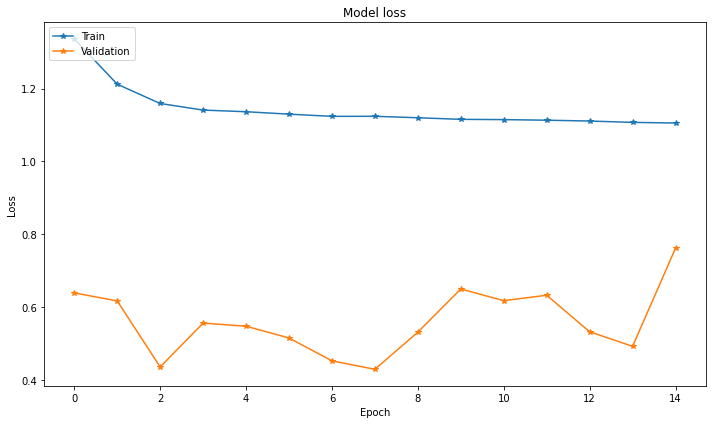

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], '*-')
plt.plot(history.history['val_loss'], '*-')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()
plt.close()

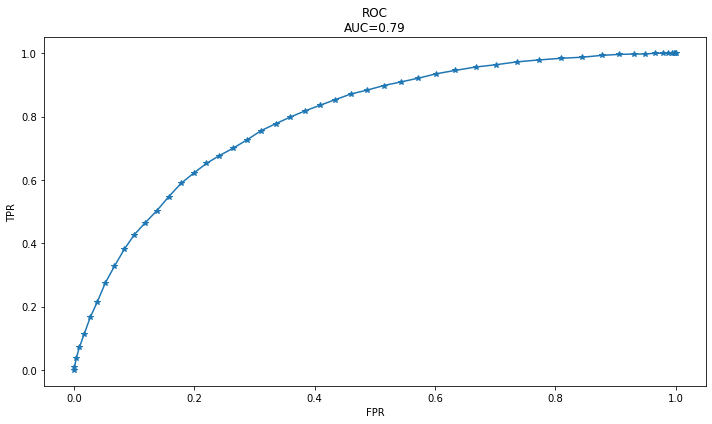

In [ ]:
predictions = model.predict([X_val_lstm, X_val_mask])

results_df, thresh_final = roc(predictions[:,1].flatten(), y_val[:,1].flatten(), 'val')
results_df = results_df.sort_values(by='fpr')

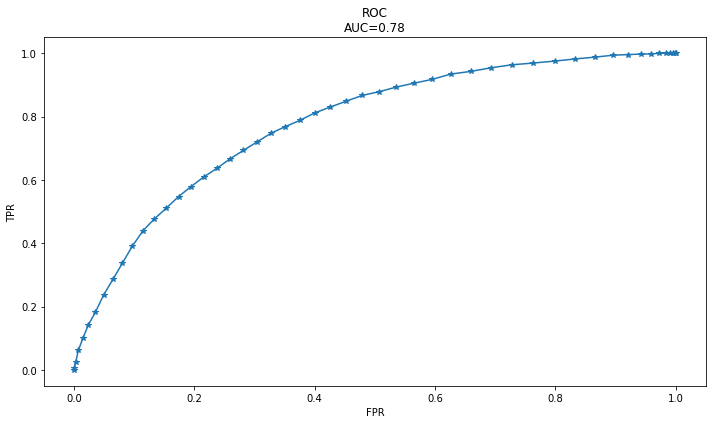

In [ ]:
predictions = model.predict([X_test_lstm, X_test_mask])

results_df, thresh_final = roc(predictions[:,1].flatten(), y_test[:,1].flatten(), 'test')
results_df = results_df.sort_values(by='fpr')